***Q1*** a)

Dataset1 - BGD converged in 15842 steps
Dataset1 - SGD converged in 7559 steps


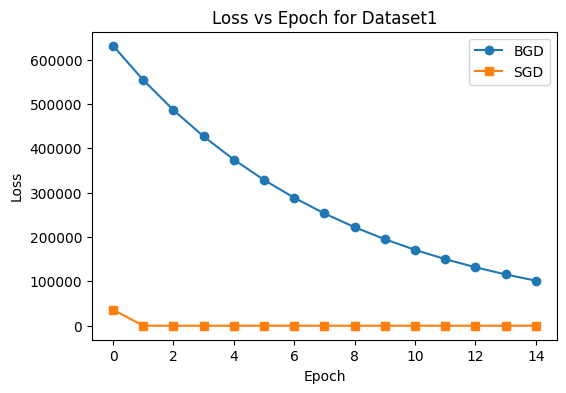

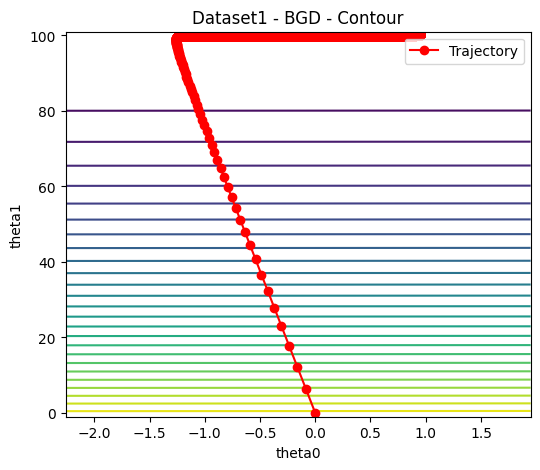

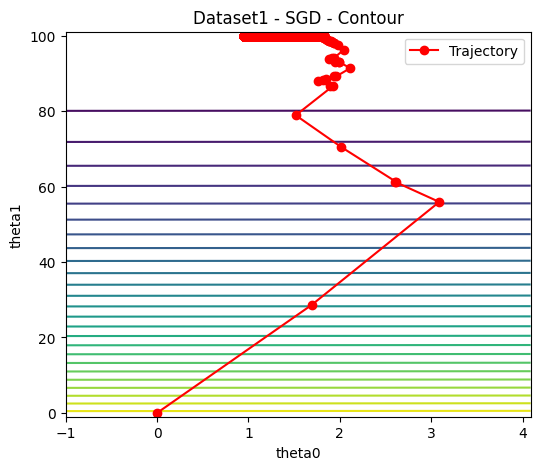

Dataset2 - BGD converged in 524 steps
Dataset2 - SGD converged in 5905 steps


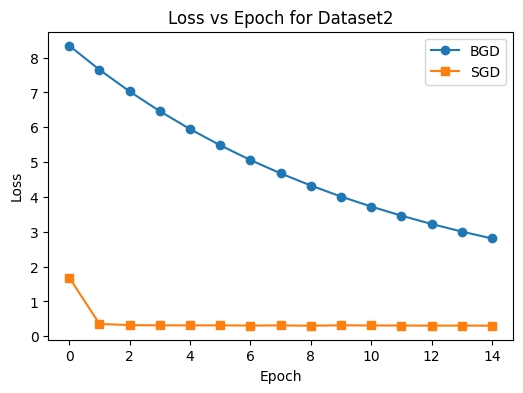

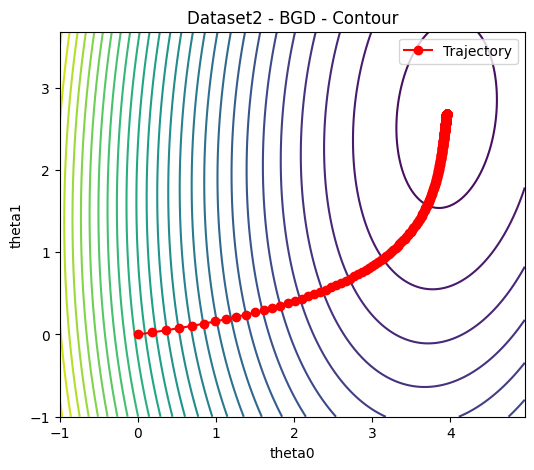

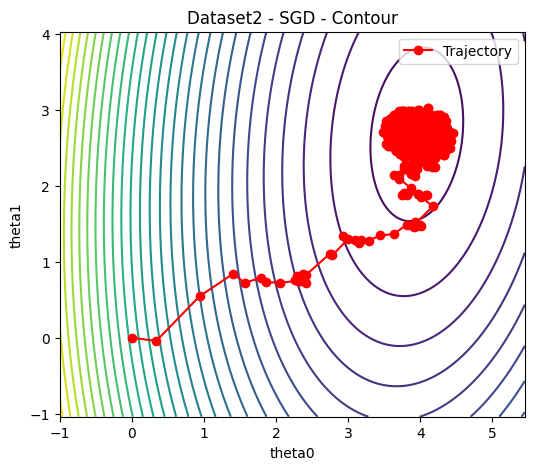

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Datasets
def generate_dataset1():
    np.random.seed(45)
    x = np.random.uniform(-20, 20, 40)
    y = 100*x + 1 + np.random.randn(40)
    return x, y

def generate_dataset2():
    np.random.seed(45)
    x = np.random.uniform(-1, 1, 40)
    y = 3*x + 4 + np.random.randn(40)
    return x, y

def compute_loss(X, y, theta):
    m = X.shape[0]
    return (1/(2*m)) * np.sum((X @ theta - y)**2)

def compute_grad(X, y, theta):
    m = X.shape[0]
    return (1/m) * X.T @ (X @ theta - y)

# Full-batch Gradient Descent
def batch_gradient_descent(X, y, theta_init, lr, epsilon=0.001):
    theta = theta_init.copy()
    theta_star = np.linalg.inv(X.T @ X) @ X.T @ y
    theta_history = [theta.copy()]
    loss_history = [compute_loss(X, y, theta)]
    steps = 0

    while np.linalg.norm(theta - theta_star) >= epsilon:
        grad = compute_grad(X, y, theta)
        theta -= lr * grad
        theta_history.append(theta.copy())
        loss_history.append(compute_loss(X, y, theta))
        steps += 1

    return np.array(theta_history), np.array(loss_history), steps

# Stochastic Gradient Descent
def stochastic_gradient_descent(X, y, theta_init, lr, epsilon=0.001):
    theta = theta_init.copy()
    theta_star = np.linalg.inv(X.T @ X) @ X.T @ y
    theta_history = [theta.copy()]
    loss_history = [compute_loss(X, y, theta)]
    steps = 0
    m = X.shape[0]

    while np.linalg.norm(theta - theta_star) >= epsilon:
        idx = np.random.permutation(m)
        for i in idx:
            xi = X[i].reshape(1,-1)
            yi = y[i]
            theta -= lr * xi.T @ (xi @ theta - yi)
            theta_history.append(theta.copy())
            loss_history.append(compute_loss(X, y, theta))
            steps += 1
            if np.linalg.norm(theta - theta_star) < epsilon:
                break

    return np.array(theta_history), np.array(loss_history), steps
# Contour plot and animation (15 frames)
def contour_plot_and_animation(X, y, theta_history, title, n_frames=15):
    theta0_vals = np.linspace(min(theta_history[:,0])-1, max(theta_history[:,0])+1, 200)
    theta1_vals = np.linspace(min(theta_history[:,1])-1, max(theta_history[:,1])+1, 200)
    Theta0, Theta1 = np.meshgrid(theta0_vals, theta1_vals)
    Z = np.zeros_like(Theta0)
    for i in range(Theta0.shape[0]):
        for j in range(Theta0.shape[1]):
            Z[i,j] = compute_loss(X, y, np.array([Theta0[i,j], Theta1[i,j]]))

    # Contour plot
    plt.figure(figsize=(6,5))
    CS = plt.contour(Theta0, Theta1, Z, levels=30, cmap='viridis')
    plt.plot(theta_history[:,0], theta_history[:,1], 'r-o', label='Trajectory')
    plt.xlabel('theta0')
    plt.ylabel('theta1')
    plt.title(f'{title} - Contour')
    plt.legend()
    plt.show()

    # Animation with 15 frames
    indices = np.linspace(0, len(theta_history)-1, n_frames, dtype=int)
    theta_sampled = theta_history[indices]
    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_xlabel('theta0')
    ax.set_ylabel('theta1')
    ax.set_title(f'{title} - Optimization Animation')
    ax.contour(Theta0, Theta1, Z, levels=30, cmap='viridis')
    line, = ax.plot([], [], 'r-o', lw=2)

    def update(frame):
        line.set_data(theta_sampled[:frame+1,0], theta_sampled[:frame+1,1])
        return line,

    anim = FuncAnimation(fig, update, frames=n_frames, interval=500)
    plt.close()
    return anim
# Loss vs Epoch (15 epochs)
def plot_loss_vs_epoch(loss_hist_bgd, loss_hist_sgd, X, y, name, n_epochs=15):
    m = X.shape[0]

    # BGD: each step = 1 epoch (full batch)
    epochs_bgd = np.arange(min(n_epochs, len(loss_hist_bgd)))
    loss_bgd = loss_hist_bgd[:len(epochs_bgd)]

    # SGD: average loss per epoch
    loss_sgd_epoch = []
    for epoch in range(n_epochs):
        start = epoch * m
        end = min((epoch + 1) * m, len(loss_hist_sgd))
        if start < len(loss_hist_sgd):
            loss_sgd_epoch.append(np.mean(loss_hist_sgd[start:end]))

    epochs_sgd = np.arange(len(loss_sgd_epoch))

    plt.figure(figsize=(6,4))
    plt.plot(epochs_bgd, loss_bgd, 'o-', label='BGD')
    plt.plot(epochs_sgd, loss_sgd_epoch, 's-', label='SGD')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Epoch for {name}')
    plt.legend()
    plt.show()

datasets = [("Dataset1", generate_dataset1()), ("Dataset2", generate_dataset2())]

# Learning rates appropriate for dataset scale
lr_dict = {"Dataset1": {"BGD":0.0005, "SGD":0.001},
           "Dataset2": {"BGD":0.05, "SGD":0.1}}

for name, (x, y) in datasets:
    X = np.vstack((np.ones_like(x), x)).T
    theta_init = np.zeros(2)

    # Full-batch GD
    theta_hist_bgd, loss_hist_bgd, steps_bgd = batch_gradient_descent(
        X, y, theta_init, lr=lr_dict[name]["BGD"])
    print(f"{name} - BGD converged in {steps_bgd} steps")

    # SGD
    theta_hist_sgd, loss_hist_sgd, steps_sgd = stochastic_gradient_descent(
        X, y, theta_init, lr=lr_dict[name]["SGD"])
    print(f"{name} - SGD converged in {steps_sgd} steps")

    # Loss vs epoch plot (15 epochs)
    plot_loss_vs_epoch(loss_hist_bgd, loss_hist_sgd, X, y, name, n_epochs=15)

    # Contour plot + animation
    anim_bgd = contour_plot_and_animation(X, y, theta_hist_bgd, f"{name} - BGD")
    anim_sgd = contour_plot_and_animation(X, y, theta_hist_sgd, f"{name} - SGD")

    # Save animations
    anim_bgd.save(f"{name}_BGD.gif", writer=PillowWriter(fps=2))
    anim_sgd.save(f"{name}_SGD.gif", writer=PillowWriter(fps=2))


***Q1*** b)

Dataset1 - BGD with momentum converged in 1517 steps
Dataset1 - SGD with momentum converged in 2498 steps


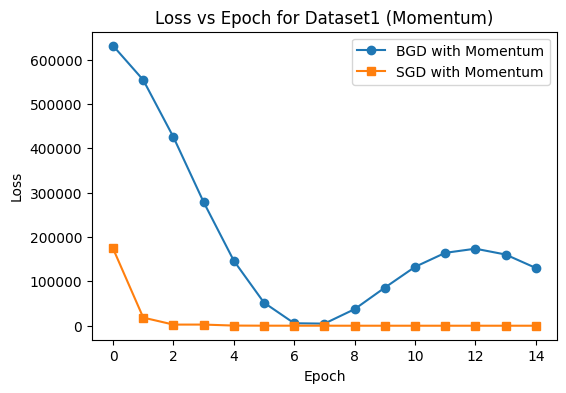

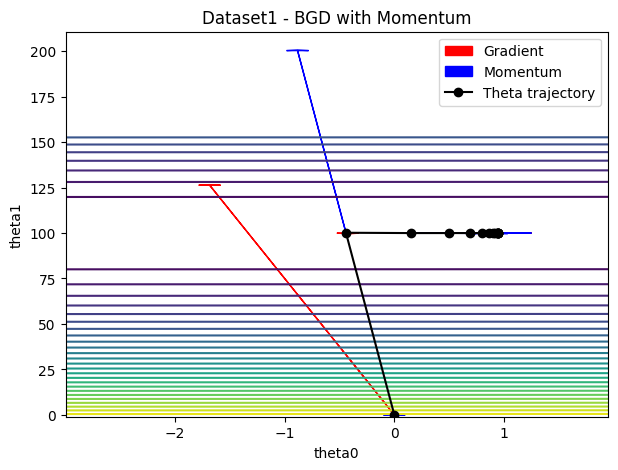

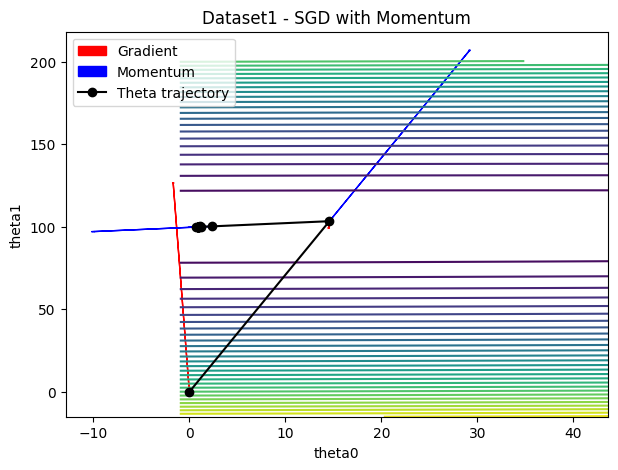

Dataset2 - BGD with momentum converged in 147 steps
Dataset2 - SGD with momentum converged in 650 steps


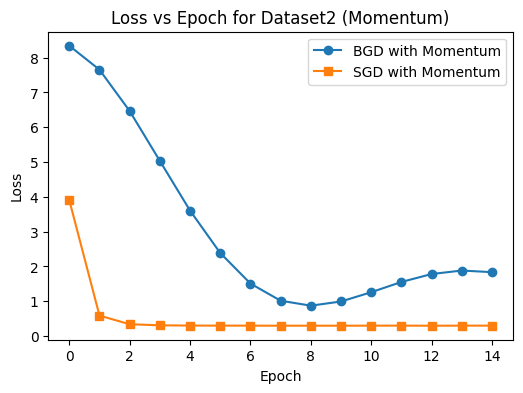

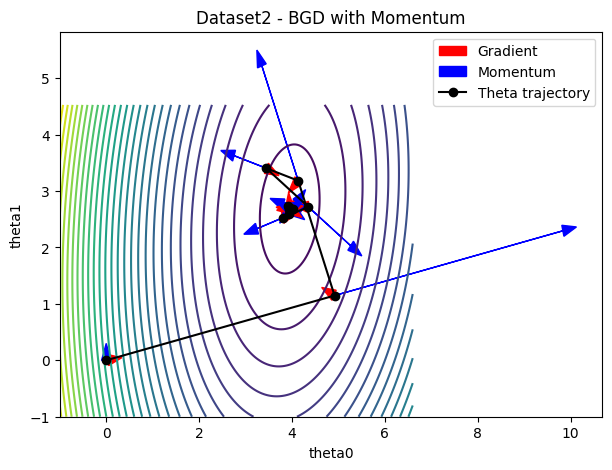

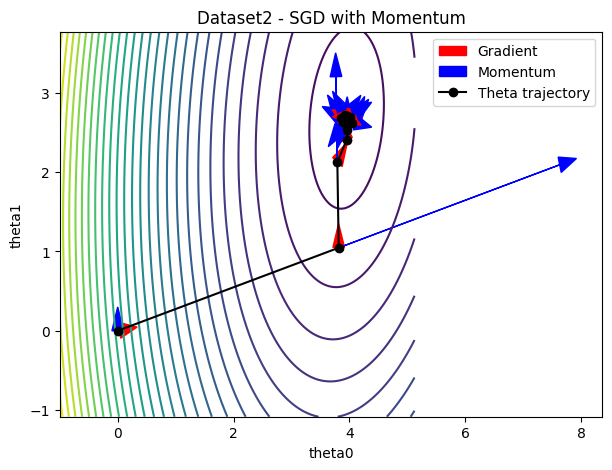

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset Generation
def generate_dataset1():
    np.random.seed(45)
    x = np.random.uniform(-20, 20, 40)
    y = 100*x + 1 + np.random.randn(40)
    return x, y

def generate_dataset2():
    np.random.seed(45)
    x = np.random.uniform(-1, 1, 40)
    y = 3*x + 4 + np.random.randn(40)
    return x, y

# Loss and Gradient
def compute_loss(X, y, theta):
    m = X.shape[0]
    return (1/(2*m)) * np.sum((X @ theta - y)**2)

def compute_grad(X, y, theta):
    m = X.shape[0]
    return (1/m) * X.T @ (X @ theta - y)

# Gradient Descent with Momentum
def gradient_descent_momentum(X, y, theta_init, lr, beta=0.9, epsilon=0.001, stochastic=False):
    theta = theta_init.copy()
    theta_star = np.linalg.inv(X.T @ X) @ X.T @ y
    v = np.zeros_like(theta)
    theta_history = [theta.copy()]
    loss_history = [compute_loss(X, y, theta)]
    steps = 0
    m = X.shape[0]

    while np.linalg.norm(theta - theta_star) >= epsilon:
        if stochastic:
            idx = np.random.permutation(m)
            for i in idx:
                xi = X[i].reshape(1,-1)
                yi = y[i]
                grad = xi.T @ (xi @ theta - yi)
                v = beta*v + lr*grad
                theta -= v
                theta_history.append(theta.copy())
                loss_history.append(compute_loss(X, y, theta))
                steps += 1
                if np.linalg.norm(theta - theta_star) < epsilon:
                    break
        else:
            grad = compute_grad(X, y, theta)
            v = beta*v + lr*grad
            theta -= v
            theta_history.append(theta.copy())
            loss_history.append(compute_loss(X, y, theta))
            steps += 1

    return np.array(theta_history), np.array(loss_history), steps

# Contour plot with vectors
def contour_plot_with_vectors(X, y, theta_history, title, n_epochs=15):
    theta0_vals = np.linspace(min(theta_history[:,0])-1, max(theta_history[:,0])+1, 200)
    theta1_vals = np.linspace(min(theta_history[:,1])-1, max(theta_history[:,1])+1, 200)
    Theta0, Theta1 = np.meshgrid(theta0_vals, theta1_vals)
    Z = np.zeros_like(Theta0)
    for i in range(Theta0.shape[0]):
        for j in range(Theta0.shape[1]):
            Z[i,j] = compute_loss(X, y, np.array([Theta0[i,j], Theta1[i,j]]))

    indices = np.linspace(0, len(theta_history)-1, n_epochs, dtype=int)
    sampled_theta = theta_history[indices]

    plt.figure(figsize=(7,5))
    CS = plt.contour(Theta0, Theta1, Z, levels=30, cmap='viridis')

    for i in range(1, len(sampled_theta)):
        theta_curr = sampled_theta[i-1]
        theta_next = sampled_theta[i]
        grad = compute_grad(X, y, theta_curr)
        momentum_vec = theta_curr - sampled_theta[i-2] if i>1 else np.zeros_like(theta_curr)

        # Plot vectors
        plt.arrow(theta_curr[0], theta_curr[1], -grad[0]*0.01, -grad[1]*0.01,
                  color='red', head_width=0.2, label='Gradient' if i==1 else "")
        plt.arrow(theta_curr[0], theta_curr[1], momentum_vec[0], momentum_vec[1],
                  color='blue', head_width=0.2, label='Momentum' if i==1 else "")

    # Trajectory of theta
    plt.plot(sampled_theta[:,0], sampled_theta[:,1], 'ko-', label='Theta trajectory')
    plt.xlabel('theta0')
    plt.ylabel('theta1')
    plt.title(title)
    plt.legend()
    plt.show()

# Loss vs Epoch
def plot_loss_vs_epoch(loss_hist_bgd, loss_hist_sgd, X, y, name, n_epochs=15):
    m = X.shape[0]

    # BGD: each step = 1 epoch (full batch)
    epochs_bgd = np.arange(min(n_epochs, len(loss_hist_bgd)))
    loss_bgd = loss_hist_bgd[:len(epochs_bgd)]

    # SGD: average loss per epoch
    loss_sgd_epoch = []
    for epoch in range(n_epochs):
        start = epoch * m
        end = min((epoch + 1) * m, len(loss_hist_sgd))
        if start < len(loss_hist_sgd):
            loss_sgd_epoch.append(np.mean(loss_hist_sgd[start:end]))

    epochs_sgd = np.arange(len(loss_sgd_epoch))

    plt.figure(figsize=(6,4))
    plt.plot(epochs_bgd, loss_bgd, 'o-', label='BGD with Momentum')
    plt.plot(epochs_sgd, loss_sgd_epoch, 's-', label='SGD with Momentum')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Epoch for {name} (Momentum)')
    plt.legend()
    plt.show()

datasets = [("Dataset1", generate_dataset1()), ("Dataset2", generate_dataset2())]

# Learning rates
lr_dict = {"Dataset1": {"BGD":0.0005, "SGD":0.001},
           "Dataset2": {"BGD":0.05, "SGD":0.005}}

for name, (x, y) in datasets:
    X = np.vstack((np.ones_like(x), x)).T
    theta_init = np.zeros(2)

    # BGD with momentum
    theta_hist_bgd_m, loss_hist_bgd_m, steps_bgd_m = gradient_descent_momentum(
        X, y, theta_init, lr=lr_dict[name]["BGD"], beta=0.9, stochastic=False)
    print(f"{name} - BGD with momentum converged in {steps_bgd_m} steps")

    # SGD with momentum
    theta_hist_sgd_m, loss_hist_sgd_m, steps_sgd_m = gradient_descent_momentum(
        X, y, theta_init, lr=lr_dict[name]["SGD"], beta=0.9, stochastic=True)
    print(f"{name} - SGD with momentum converged in {steps_sgd_m} steps")

    # Loss vs epoch
    plot_loss_vs_epoch(loss_hist_bgd_m, loss_hist_sgd_m, X, y, name, n_epochs=15)

    # Contour plots with vectors
    contour_plot_with_vectors(X, y, theta_hist_bgd_m, f"{name} - BGD with Momentum")
    contour_plot_with_vectors(X, y, theta_hist_sgd_m, f"{name} - SGD with Momentum")


# Observations

**Convergence Speed:**

Momentum accelerated convergence for both datasets in BGD and SGD, reaching the ϵ-neighborhood faster than vanilla GD.

For Dataset 1, both BGD and SGD with momentum converged much quicker due to consistent gradient directions.

For Dataset 2, BGD with momentum converged in ~147 steps, but SGD with momentum took ~8 × 10⁵ steps because of small feature magnitudes and an overly large learning rate causing oscillations.

**Momentum Behavior:**
The momentum term averaged recent gradients, smoothing the trajectory and reducing oscillations. Over iterations, the momentum direction aligned with the gradient direction, providing faster, smoother descent.

**Contour Plot Insights:**
Red arrows (gradients) showed the instantaneous direction, blue arrows (momentum) showed the accumulated direction, and the black line (θ trajectory) became smoother with momentum—showing reduced zig-zag movement compared to vanilla GD.

**Summary:**
Momentum greatly accelerates convergence when parameters are well-tuned but can slow or destabilize training if gradients are small or noisy.